In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import matplotlib.pyplot as plt
import ipywidgets as widgets
import numpy as np

# from ipywidgets import interact
import sys

root_dir = Path().absolute().parent
if not root_dir in sys.path: sys.path.append(str(root_dir))
print(root_dir)

from general.network import Network, distr_params
%matplotlib widget

/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme


### 2 population model with single synapses

* "inference" yields values for $\gamma_p$, $\delta_p$ and $\nu_p^{(m)}$
* plot manifolds arising from single parameter definitions of $\gamma$ and $\nu^{(m)}$
* plot overall manifold (with sensicle dimensions) and overall variance of parameters

### Manifold for $\nu_I^{(m)}$
only 3 free parameters: $\tau_I$, $\tau_E$, $\varepsilon$

$\nu^{(m)} = \frac{1}{2 \pi} \frac{\sigma_{\dot{V}}}{\sigma_V}$

In [2]:
from general.network import get_nu_bar, get_q

net = Network(eta=0.4, eps=0.6)
## inhibitory population
net.register_population(nu_bar=3.0, alpha_0=0.01, J0=-1.0)
net.populations[0].register_synapse(tau_I=0.005)

## excitatory population
net.register_population(nu_bar=1.0, alpha_0=0.02, J0=1.0)
net.populations[1].register_synapse(tau_I=0.1)

net.solve_selfcon()

distr = net.export_distr()

In [3]:
# net.set_param("tau_I_p0_s0", 0.01)
# net.print_current_state()
# hasattr(net.populations[0],'tau_I')

In [ ]:
from scipy.optimize import root
from typing import List


def match_all(
    input: List[float], net: Network, var_names: List[str], root_function, bounds=None
):

    assert len(input) == len(
        var_names
    ), "Input length does not match variable names length."
    # n_inputs = len(var_names)
    assert len(input) == len(
        root_function(net)
    ), "Input length does not match root searches length."

    penalty = np.full(len(input), -np.inf)
    if bounds is not None:
        # penalty = 0.0
        for i, key in enumerate(var_names):
            boundaries = bounds.get(key, None)
            if boundaries is not None:
                if not boundaries[0] <= input[i] <= boundaries[1]:
                    dBounds = boundaries[1] - boundaries[0]
                    dVar = np.min(np.abs(input[i] - np.array(boundaries)))
                    penalty[i] = 1e6 * dVar / dBounds

    for key, val in zip(var_names, input):
        net.set_param(key, val)

    net.solve_selfcon()
    return_vals = np.array(root_function(net))
    np.maximum(return_vals, penalty, out=return_vals)
    return return_vals


def find_root(net, bounds, root_function, start_guess=None, ct_max=10):

    success = False
    ct = 0
    while not success:

        if (ct > 0) | (start_guess is None):
            start_guess = np.random.uniform(*np.array([b for b in bounds.values()]).T)
        # print ("Starting guess:", start_guess)
        try:
            res = root(
                match_all,
                start_guess,
                args=(
                    net,
                    bounds.keys(),
                    root_function,
                    bounds,
                ),
                tol=1e-12,
                method="krylov",
                options={"maxiter": 50},
            )
            success = res.success & np.all(np.abs(res.fun) < 1e-6)
            if success:
                break
            # if success:
            #     print(res)
        except:
            pass

        ct += 1
        if ct > ct_max:
            break

    if success:
        return res.x
    else:
        return None

In [ ]:
ref_vals = {
    "eta": 0.4,
    "eps": 0.6,
    "tau_I_p0_s0": 0.005,
    "tau_I_p1_s0": 0.1,
    "alpha_0_p0": 0.01,
    "alpha_0_p1": 0.02,
}
for key in ref_vals:
    net.set_param(key, ref_vals[key])
net.solve_selfcon()

x_steps = 21
y_steps = 21

# iter_vars = ["alpha_0_p0", "alpha_0_p1"]
iter_vars = ["eps", "eta"]

bounds_raw = {
    "eps": [0.01, np.sqrt(1 / 2)],
    "eta": [0.01, 1],
    # "tau_I_p0_s0": [0.001, 0.02],
    "tau_I_p1_s0": [0.001, 0.2],
    "alpha_0_p0": [0.0, 0.04],
    "alpha_0_p1": [0.0, 0.04],
}

root_function = lambda net: (
    net.populations[0].gamma - distr[0].gamma,
    net.populations[1].gamma - distr[1].gamma,
    net.populations[0].nu_max - distr[0].nu_max,
    # net.populations[1].nu_max - distr[1].nu_max,
)

In [ ]:
from multiprocessing import Pool
import copy


x_iter = np.linspace(*bounds_raw[iter_vars[0]], x_steps)
y_iter = np.linspace(*bounds_raw[iter_vars[1]], y_steps)


result_array = {}
bounds = {}
for key in list(bounds_raw.keys()):
    if key in iter_vars:
        continue
    bounds[key] = bounds_raw[key]
    result_array[key] = np.full((x_steps, y_steps), np.nan)


def evaluate_inner_loop(args):
    i, net = args

    results = {key: np.full(y_steps, np.nan) for key in result_array.keys()}

    net.set_param(iter_vars[0], x_iter[i])

    # net.print_current_state()
    prev_guess = None
    for j in range(y_steps):
        net.set_param(iter_vars[1], y_iter[j])

        root_vals = find_root(
            net, bounds, root_function, start_guess=prev_guess, ct_max=10
        )

        if root_vals is not None:
            for a, key in enumerate(result_array.keys()):
                results[key][j] = root_vals[a]
            prev_guess = root_vals

    return i, results


with Pool(6) as pool:
    args_list = [(i, copy.deepcopy(net)) for i in range(x_steps)]
    out = pool.map(evaluate_inner_loop, args_list)

    for i, results in out:
        for key in result_array:
            result_array[key][i, :] = results[key]

/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:132: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var_V_dot / var_V) / (2 * math.pi) if var_V > 0 else np.nan
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  q = fsolve(self.selfcon, q0, xtol=1e-12)
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:132: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(var_V_dot / var_V) / (2 * math.pi) if var_V > 0 else np.nan
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  q = fsolve(self.selfcon, q0, xtol=1e-12)
/home/wollex/Documents/Science/WolfGroup/DarkMatter/Programme/general/network.py:132: 

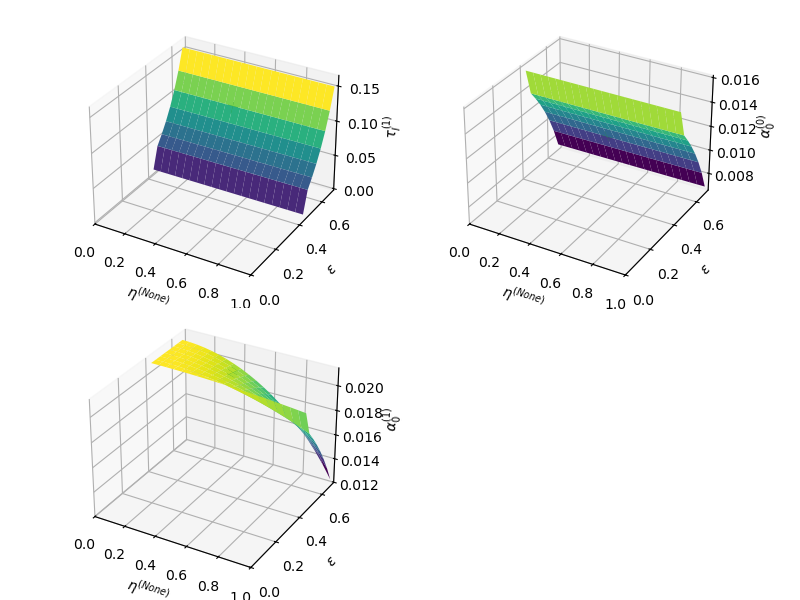

In [ ]:
from general.network import parse_name_and_indices

X, Y = np.meshgrid(y_iter, x_iter)


fig = plt.figure(figsize=(8, 6))
for i, key in enumerate(result_array):

    ax = fig.add_subplot(2, 2, i + 1, projection="3d")
    # ax.scatter3D(X[:-1,:], Y[:-1,:], result_array[key][:-1,:], c="tab:red", s=2, label=key)
    ax.plot_surface(
        X[:-1, :], Y[:-1, :], result_array[key][:-1, :], cmap="viridis", label=key
    )
    ax.scatter3D(
        ref_vals[iter_vars[1]],
        ref_vals[iter_vars[0]],
        ref_vals[key],
        c="tab:green",
        s=50,
        # label="ref_" + key,
    )
    # ax.legend()
    ax.set_xlim([0, bounds_raw[iter_vars[1]][1]])
    ax.set_ylim([0, bounds_raw[iter_vars[0]][1]])
    # ax.set_xlabel("$\\eta$")
    # ax.set_ylabel("$\\varepsilon$")
    name, indices = parse_name_and_indices(iter_vars[1], ["p", "s"])
    ax.set_xlabel(f"$\\{name}^{{({indices[0]})}}$")
    name, indices = parse_name_and_indices(iter_vars[0], ["p", "s"])
    if name == "eps":
        name = "varepsilon"
    ax.set_ylabel(f"$\\{name}$")

    name, indices = parse_name_and_indices(key, ["p", "s"])
    ax.set_zlabel(f"$\\{name}^{{({indices[0]})}}$")
    # ax.set_title(f"$\\{name}^{{({indices[0]})}}$")
    # ax.set_zlim([0, ax.get_zlim()[1]])
plt.tight_layout()
# plt.savefig("manifolds.png", dpi=300)
plt.show()

(array([[ 0.,  0.,  0.,  3.,  3.,  3.,  3.,  8., 11., 26.],
        [ 1.,  3.,  4.,  3.,  4.,  6.,  8.,  4.,  6., 27.],
        [ 3.,  3.,  4.,  4.,  5.,  3.,  8., 10., 12., 30.],
        [ 3.,  3.,  4.,  6.,  5.,  7., 10., 10., 18., 33.],
        [ 1.,  3.,  2.,  5.,  7.,  8., 10., 13., 16., 50.],
        [ 0.,  1.,  2.,  4.,  4., 10., 12., 15., 26., 58.],
        [ 0.,  0.,  0.,  2.,  1.,  4., 11., 18., 29., 86.],
        [ 0.,  0.,  0.,  0.,  1.,  1.,  3., 10., 25., 62.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2., 59.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., 35.]]),
 array([0.00574552, 0.00685719, 0.00796887, 0.00908054, 0.01019222,
        0.01130389, 0.01241557, 0.01352724, 0.01463891, 0.01575059,
        0.01686226]),
 array([0.01590357, 0.01639111, 0.01687866, 0.0173662 , 0.01785374,
        0.01834128, 0.01882883, 0.01931637, 0.01980391, 0.02029145,
        0.02077899]),
 <matplotlib.collections.QuadMesh at 0x7061423f8cd0>)

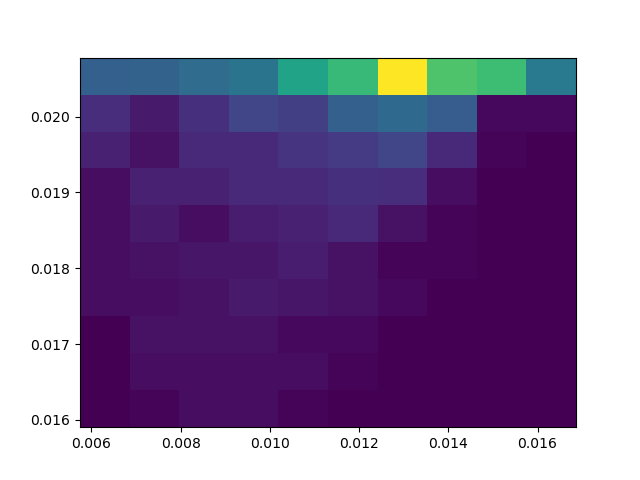

In [ ]:
plt.figure()
mask = ~np.isnan(result_array["tau_I_p1_s0"])
plt.hist2d(result_array["alpha_0_p0"][mask], result_array["alpha_0_p1"][mask])

In [ ]:
for key in ref_vals:
    net.set_param(key, ref_vals[key])
net.solve_selfcon()

net.set_param("tau_I_p0_s0", 0.0049)
# net.print_current_state()

bounds_ = {}
for key in bounds_raw:
    if key in ["tau_I_p0_s0", "tau_I_p1_s0"]:
        continue
    bounds_[key] = bounds_raw[key]
print("bounds:", bounds_)
root_vals = find_root(net, bounds_, ct_max=20)
print("Root vals at reference point:", root_vals)
# print("Root vals at reference point:")
# for a, key in enumerate(bounds_):
#     print(f"{key}: {root_vals[a]}")

bounds: {'eps': [0.01, np.float64(0.7071067811865476)], 'eta': [0.01, 1], 'alpha_0_p0': [0.0, 0.04], 'alpha_0_p1': [0.0, 0.04]}
Starting guess: [0.59810139 0.49748586 0.03696002 0.03553445]
Starting guess: [0.33658992 0.01390733 0.02227321 0.03486497]
Starting guess: [0.26386085 0.79863994 0.01026229 0.0358338 ]
Starting guess: [0.59633909 0.07110285 0.03681586 0.01626187]
Starting guess: [0.43190857 0.76039548 0.0179234  0.00118629]
Starting guess: [0.56604121 0.26239147 0.03273857 0.01052677]
Starting guess: [0.04242019 0.26630432 0.03745796 0.01294604]
Starting guess: [0.42973778 0.8942785  0.01904003 0.02740452]
Starting guess: [0.09401141 0.18853494 0.00354924 0.00791433]
Starting guess: [0.54534166 0.43249481 0.00984988 0.03432718]
Starting guess: [0.14444926 0.47003769 0.00860477 0.01898167]
Starting guess: [0.47909993 0.31256066 0.03739356 0.03219511]
Starting guess: [0.69369172 0.7306783  0.02655278 0.03435007]
Starting guess: [0.60952582 0.39076796 0.02298531 0.02882944]
Star

In [ ]:
from scipy.optimize import root

net.set_param("eta", 0.4)
net.set_param("eps", 0.6)

res = root(
    match_all,
    (0.01, 0.1, 0.01, 0.01),
    args=(net, bounds.keys(), root_function, bounds),
    tol=1e-12,
    method="krylov",
    options={"maxiter": 100},
)
# res = root(match_all, (0.5, 0.5, 0.02, 0.02), tol=1e-12, method="krylov")
res

 message: A solution was found at the specified tolerance.
 success: True
  status: 1
     fun: [-8.848e-02 -8.891e-02 -8.559e-04  2.872e-03]
       x: [ 4.999e-03  9.817e-02  1.258e-02  2.259e-02]
     nit: 10
  method: krylov
    nfev: 54